# Word Embeddings

În procesarea limbajului natural, **încorporarea cuvintelor** este un termen folosit pentru reprezentarea cuvintelor sub forma unui *vector care codifică și ***sensul*** cuvintelor*, astfel încât cuvintele care sunt mai apropiate ca sens să fie apropiate și în spațiul vectorial. 

Cu ajutorul embeddings-urilor putem surprinde contextul unui cuvânt dintr-un document, asemănarea semantică și sintactică, relația cu alte cuvinte etc. 

Printre tehnicile de vectorizare cu reținere a sensului, amintim: word2vec, GloVe, fastText


<img src= "https://miro.medium.com/max/1356/1*5F4TXdFYwqi-BWTToQPIfg.jpeg">

## 1. Word2vec

Word2Vec este una dintre cele mai populare tehnici de încorporare a cuvintelor ce folosește o *rețea neuronală superficială*. A fost dezvoltat de Tomas Mikolov în 2013 la Google (articolul [aici](https://arxiv.org/pdf/1310.4546.pdf)).

Word2vec antrenează modele de cuvinte cu ajutorul cuvintelor învecinate din corpus, și face acest lucru în din două moduri:

*   fie folosind context pentru a prezice un cuvânt țintă (o metodă cunoscută sub numele de **CBOW** - Continous Bag Of Words, sau "sac continuu de cuvinte")
*   fie folosind un cuvânt pentru a prezice un context țintă, care se numește **skip-gram**.

Noi vom folosi metoda din urmă, deoarece produce rezultate mai precise pe seturi mari de date. 

<img src= "https://wiki.pathmind.com/images/wiki/word2vec_diagrams.png" width="500" height="300">



### CBOW - Continous Bag of Words

Această arhitectură este foarte asemănătoare cu o rețea neuronală feed forward. 

Intuiția din spatele acestui model este destul de simplă. Să presupunem că avem expresia „Have a great day”, cuvântul țintă „a” și cuvintele de context să fie [„have”, „great”, „day”]. Acest model va lua reprezentările distribuite ale cuvintelor de context pentru a încerca să prezică cuvântul țintă. 



### Modelul Skip-Gram 

Modelul skip-gram este o rețea neuronală simplă cu un strat ascuns antrenat pentru a prezice probabilitatea ca un anumit cuvânt să fie prezent atunci când este prezent un cuvânt de intrare. În mod intuitiv, vă puteți imagina că modelul skip-gram este opusul modelului CBOW. În această arhitectură, modelul ia cuvântul curent ca intrare și încearcă să prezică cu precizie cuvintele dinainte și după acest cuvânt curent. Acest model încearcă în esență să învețe și să prezică cuvintele de context în jurul cuvântului de intrare specificat. Procesul poate fi descris vizual, așa cum se vede mai jos. 

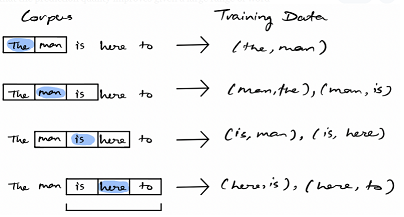

Așadar, cuvântul țintă se selectează cu ajutorul unei fereastre rulante. Datele de antrenare penru rețeaua neuronală constau din combinații ale cuvântului țintă și toate celelalte cuvinte din fereastră. Odată ce modelul este antrenat, putem obține, în esență, o probabilitate ca un cuvânt să fie un cuvânt de context pentru o anumită țintă. Următoarea imagine reprezintă arhitectura unei rețele pentru modelul skip-gram.

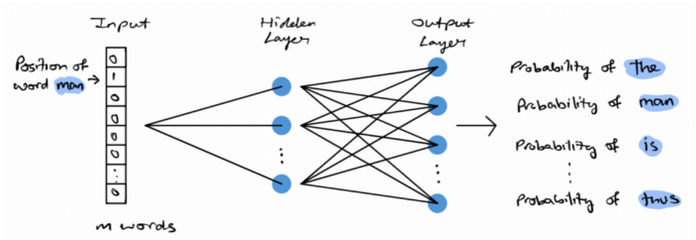

Un corpus poate fi reprezentat ca un vector de mărime N, unde fiecare element din N corespunde unui cuvânt din corpus. În timpul procesului de antrenare, avem o pereche țintă-context, iar array-ul de la intrare va avea 0 în toate elementele, cu excepția cuvântului țintă, ce va fi 1. Astfel, stratul ascuns va învăța reprezentărea tuturor cuvintelor, obținând un spațiu de încorporare d-dimensional. Stratul de ieșire este un strat dens cu o funcție de activare softmax, ce va produce un vector de aceeași dimensiune ca și intrarea, fiecare element din vector constând dintr-o probabilitate ce indică asemănarea dintre cuvântul țintă și cuvântul asociat în corpus.

### Implementare

Ne vom ajuta de librăria Gensim pentru a implementa vectorizarea word2vec, și de nltk pentru tokenizare.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/bogdan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bogdan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
! pip install gensim==4.0.1

In [ ]:
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import Word2Vec as w2v

In [ ]:
from urllib.request import urlretrieve
urlretrieve('https://raw.githubusercontent.com/vatsal220/medium_articles/main/w2v/data/shakespeare.txt', 'shakespeare.txt')

('shakespeare.txt', <http.client.HTTPMessage at 0x7fc1ac03b6d0>)

In [ ]:
# constants
PATH = './shakespeare.txt'
sw = stopwords.words('english')
plt.style.use('ggplot')

# import data
lines = []
with open(PATH, 'r') as f:
    for l in f:
        lines.append(l)

print(lines[:10])

['"ACT I"\n', '"SCENE I. London. The palace."\n', '"Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others"\n', '"So shaken as we are, so wan with care,"\n', '"Find we a time for frighted peace to pant,"\n', '"And breathe short-winded accents of new broils"\n', '"To be commenced in strands afar remote."\n', '"No more the thirsty entrance of this soil"\n', '"Shall daub her lips with her own children\'s blood,"\n', '"Nor more shall trenching war channel her fields,"\n']


### Preprocesarea datelor

*   Cuvintele-stop eliminate din aceste rânduri aparțin unui vocabular modern. Aplicația și datele au o importanță ridicată pentru tipul de tactici de preprocesare necesare pentru curățarea cuvintelor.
*   În scenariul nostru, cuvinte precum „you” sau „yourself” ar fi prezente în cuvintele oprite și eliminate din rânduri, cu toate acestea, deoarece acestea sunt date de text Shakespeare, aceste tipuri de cuvinte nu ar fi folosite. În schimb, „thou” sau „thyself” ar putea fi util de eliminat. 
*   Aici nu vom intra în detalii extreme în identificarea cuvintelor stop dintr-un secol diferit, dar fiți conștienți că ar trebui. 





In [ ]:
# remove new lines
lines = [line.rstrip('\n') for line in lines]

# make all characters lower
lines = [line.lower() for line in lines]

# remove punctuations from each line
lines = [line.translate(str.maketrans('', '', string.punctuation)) for line in lines]

# tokenize
lines = [word_tokenize(line) for line in lines]

def remove_stopwords(lines, sw = sw):
    '''
    The purpose of this function is to remove stopwords from a given array of 
    lines.
    
    params:
        lines (Array / List) : The list of lines you want to remove the stopwords from
        sw (Set) : The set of stopwords you want to remove
        
    example:
        lines = remove_stopwords(lines = lines, sw = sw)
    '''
    
    res = []
    for line in lines:
        original = line
        line = [w for w in line if w not in sw]
        if len(line) < 1:
            line = original
        res.append(line)
    return res
    
filtered_lines = remove_stopwords(lines = lines, sw = sw)

print(filtered_lines[:10])

[['act'], ['scene', 'london', 'palace'], ['enter', 'king', 'henry', 'lord', 'john', 'lancaster', 'earl', 'westmoreland', 'sir', 'walter', 'blunt', 'others'], ['shaken', 'wan', 'care'], ['find', 'time', 'frighted', 'peace', 'pant'], ['breathe', 'shortwinded', 'accents', 'new', 'broils'], ['commenced', 'strands', 'afar', 'remote'], ['thirsty', 'entrance', 'soil'], ['shall', 'daub', 'lips', 'childrens', 'blood'], ['shall', 'trenching', 'war', 'channel', 'fields']]


Încorporarea

In [ ]:
w = w2v(
    filtered_lines,
    min_count=3,  
    sg = 1,     # sg=1 inseamna ca se foloseste skip-gram, sg=0 inseamna ca se foloseste CBOW  
    window=7      
)       

print(w.wv.most_similar('thou'))

emb_df = (
    pd.DataFrame(
        [w.wv.get_vector(str(n)) for n in w.wv.key_to_index],
        index = w.wv.key_to_index
    )
)
print(emb_df.shape)
emb_df.head()

[('thyself', 0.8206092119216919), ('art', 0.8119622468948364), ('villain', 0.7814672589302063), ('dost', 0.7721075415611267), ('kill', 0.7245450615882874), ('wilt', 0.7039985656738281), ('wherefore', 0.7019933462142944), ('hast', 0.6940232515335083), ('fellow', 0.69318026304245), ('traitor', 0.6915873885154724)]
(11628, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
thou,-0.056271,-0.120362,0.543966,0.777652,-0.345296,-0.539263,0.313180,0.513947,-0.269651,-0.288437,...,0.292142,0.076872,0.318553,0.101571,0.975488,0.587843,-0.373520,-0.413528,-0.042730,0.362290
thy,-0.026303,0.199432,0.389632,0.333577,0.007617,-0.346941,0.170922,0.775028,-0.130703,-0.353451,...,0.165199,-0.061137,0.527472,-0.253437,0.462431,0.374593,-0.264580,-0.389143,-0.049726,0.084750
shall,0.083608,0.144119,0.179330,0.041682,0.513977,-0.064445,0.083410,0.368475,-0.195795,0.093562,...,0.567188,0.149746,0.163660,-0.031201,0.615760,0.201478,0.217449,-0.010914,0.259846,0.059914
thee,-0.248432,0.263531,0.403060,0.314810,-0.010920,-0.223445,0.189212,0.585915,-0.085080,-0.267452,...,0.372245,0.103209,0.007200,-0.153249,0.846941,0.422689,0.009411,0.048848,0.128691,-0.043446
good,0.038401,0.102235,0.130424,-0.113005,-0.159152,0.059692,0.195775,0.762033,-0.160952,-0.173738,...,0.366166,-0.177679,0.443306,0.049808,0.553153,-0.109883,0.079910,-0.226384,0.265363,-0.176894


Dacă spre exemplu vrem să vedem cuvintele cele mai similare ale cuvântului 'thou':

In [ ]:
print(w.wv.most_similar('thou'))

[('thyself', 0.8206092119216919), ('art', 0.8119622468948364), ('villain', 0.7814672589302063), ('dost', 0.7721075415611267), ('kill', 0.7245450615882874), ('wilt', 0.7039985656738281), ('wherefore', 0.7019933462142944), ('hast', 0.6940232515335083), ('fellow', 0.69318026304245), ('traitor', 0.6915873885154724)]


### Incarcarea modelelor Word2Vec + Vizualizari

Folosind biblioteca `gensim` putem descarcat si modele Word2Vec deja antrenate pe corpusuri mari. Un astfel de model este modelul celor de la Google.

In [ ]:
import gensim.downloader as api
google_model = api.load("word2vec-google-news-300")

In [ ]:
google_model.most_similar("cat")

[('cats', 0.8099379539489746),
 ('dog', 0.760945737361908),
 ('kitten', 0.7464985251426697),
 ('feline', 0.7326234579086304),
 ('beagle', 0.7150582671165466),
 ('puppy', 0.7075453400611877),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931973457336),
 ('chihuahua', 0.6709762215614319)]

In [ ]:
google_model.similarity("cat", "feline")

0.73262334

Folosind proprietatea de mai jos putem accesa vocabularul modelului Word2Vec

In [ ]:
vocab = google_model.index_to_key
print(len(vocab))
print(vocab[:20])

3000000
['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are']


Putem acum incerca sa generam vectori dupa formule de tipul: `king - man + woman`

In [ ]:
google_model.most_similar(positive=["king", "woman"], negative=["man"], topn=5)

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581)]

In [ ]:
google_model.most_similar(positive=["doctor", "she"], negative=["he"], topn=5)

[('nurse', 0.6588720679283142),
 ('gynecologist', 0.647172212600708),
 ('nurse_practitioner', 0.6255376935005188),
 ('midwife', 0.6002784371376038),
 ('pediatrician', 0.5921324491500854)]

In [ ]:
google_model.most_similar(positive=["computer_programmer", "woman"], negative=["man"], topn=5)

[('homemaker', 0.5627118945121765),
 ('housewife', 0.5105047225952148),
 ('graphic_designer', 0.505180299282074),
 ('schoolteacher', 0.497949481010437),
 ('businesswoman', 0.493489146232605)]

Puteti observa cum in ultimele doua exemple este ilustrata una din cele mai mari probleme ale embedding-urilor: gender bias.

Problema provine de la faptul ca gender bias-ul din textele cu care a fost antrenat modelul este incorporat si in vectorii calculati pentru cuvinte. In ultimii ani s-a lucrat la proiectarea unor metode pentru a inlatura acest efect (de-biasing) insa acestea depasesc scopul acestui laborator.

Pentru a vizualiza embedding-urile pentru o multime de cuvinte trebuie sa tinem cont ca nu putem afisa grafice in mai mult de 3 dimensiuni.

Pentru a realiza un plot cu word embeddings, trebuie mai intai sa aplicam o reducere a dimensionalitatii asupra vectorilor, pentru a-i aduce in 2D. O Astfel de metoda este [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (Principal Component Analysis). Aceasta metoda reduce numarul de dimensiuni si pastreaza pe cat mai mult posibil varianta multimii de vectori.

In [ ]:
# vom plota embedding-urile pentru urmatoarele cuvinte
words = ["king", "cat", "table"]

# acestia sunt vectorii lor
vectors = [google_model[word] for word in words]

In [ ]:
from sklearn.decomposition import PCA

# folosim PCA pentru a reduce vectorii la 2D
pca = PCA(n_components=2)
pca.fit(vectors)
vectors_2d = pca.transform(vectors)

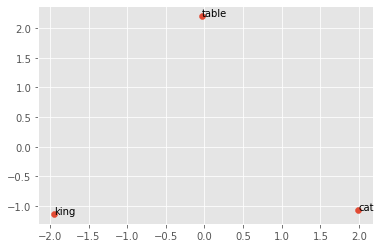

In [ ]:
import matplotlib.pyplot as plt

x = [v[0] for v in vectors_2d]
y = [v[1] for v in vectors_2d]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(words):
    ax.annotate(txt, (x[i], y[i]))

plt.show()

Biblioteca `gensim` vine si cu un corpus destul de variat de texte (`text8`), deja preprocesat pe care il puteti folosi pentru a antrena un model Word2Vec de la zero.

In [ ]:
text8 = api.load("text8")  # descarcam corpusul
text8_model = w2v(text8).wv

In [ ]:
print(text8_model.most_similar('shall'))

[('will', 0.7937530279159546), ('should', 0.7918503880500793), ('must', 0.788528561592102), ('would', 0.7145153880119324), ('ought', 0.7112311720848083), ('could', 0.7007983326911926), ('might', 0.7002084255218506), ('cannot', 0.6953482031822205), ('let', 0.6724261045455933), ('may', 0.6539021134376526)]


## 2. GloVe 

GloVe este alta metoda de determinare a embedding-urilor ce foloseste concepte elementare din statistica. In timp ce Word2vec, se bazeaza doar pe "local statistics" (aparitia cuvintelor la nivelul unei singure propozitii), GloVe incorporeaza "global statistics" (word co-occurrence matrix).

Sa consideram, spre exemple, doua cuvinte care apar in contexte/ferestre/windows comune in textele din corpus. Daca acestea apar de $100$ de ori sau de $1000$ de ori impreuna, modelul Word2Vec nu va fi afectat foarte mult (perechea va aparea mai des in datele de antrenare, dar nu va influenta direct predictia modelului). GloVe rezolva acest neajuns prin calculul matricei de co-occurrence in care pentru fiecare pereche de cuvinte numara de cate ori au aparut aceste cuvinte in acelasi context.

Exemplu, pentru un corpus format doar din propozitia "the cat sat on the mat", folosind o fereastra de dimensiune 2, avem urmatoarea co-ocurence matrix:

![co-ocurence matrix](https://miro.medium.com/max/434/1*QWcK8CIDs8kMkOwsOxvywA.png)

Unde M[i][j] = numarul de aparitii ale secventei $w_i w_j$ la nivelul intregului corpus. 

Plecand de la aceasta matrice se ajunge la o ecuatie, cu o functie de cost (optimizare). Mai multe detalii explicate [aici](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010).

## 3. FastText

fastText este o altă metodă de încorporare a cuvintelor - o extensie a modelului word2vec. În loc să învețe vectori pentru cuvinte direct, fastText reprezintă fiecare cuvânt ca un n-gram de caractere. 

De exemplu, dacă avem cuvântul „artificial” cu n=3, reprezentarea fastText a acestui cuvânt va fi <ar, art, rti, tif, ifi, fic, ici, ial, al>, unde parantezele unghiulare indică începutul și sfârșitul cuvântului. Acest lucru ajută la captarea sensului cuvintelor mai scurte și permite înglobărilor să "înțeleagă" sufixele și prefixele. Odată ce cuvântul a fost reprezentat folosind n-grame la nivel de caracter, se folosește un model skip-gram pentru a le învăța. Metoda folosită la antrenarea unui model fastText este [*train_supervised*](https://fasttext.cc/docs/en/supervised-tutorial.html).

Avantaj - fastText funcționează bine în vectorizarea cuvintelor rare - chiar dacă un cuvânt nu a fost văzut în timpul antrenării, acesta poate fi împărțit în n-grame pentru a obține înglobarea acestuia. 

Pentru fastText există o librărie Python dedicată. Următoarele 4 celule de cod necesită multă memorie pentru execuție, așa că nu le vom executa acum, sunt cu titlu informativ.

In [ ]:
! pip install fastText

Cei de la fastText au realizat o serie de vectori preantrenați pe corpusurile Common Crawl și Wikipedia, pentru 157 de limbi! Ei se găsesc [aici](https://fasttext.cc/docs/en/crawl-vectors.html). Aceste modele au fost antrenate folosind CBOW iar dimensiunea vectorilor este de 300. Ei pot fi folosiți la vectorizarea textelor pe care dorim să le folosim la clasificare, sau la orice alt task ce necesită texte vectorizate.

In [ ]:
import fasttext.util
fasttext.util.download_model('ro', if_exists='ignore')  # Română
ft = fasttext.load_model('cc.ro.300.bin')

Putem reduce dimensiunea vectorilor, pentru simplitate:

In [ ]:
import fasttext
ft.get_dimension()
fasttext.util.reduce_model(ft, 100)
ft.get_dimension()

100

Și acum putem utiliza acești vectori pentru a calcula, de exemplu, cele mai apropiate cuvinte din spațiu ale unui alt cuvânt:

In [ ]:
print(ft.get_nearest_neighbors('bună'))

[(0.8661828637123108, 'excelentă'), (0.8131385445594788, 'serioasă'), (0.8016242384910583, 'sigură'), (0.8003990650177002, 'proastă'), (0.7888690829277039, 'perfectă'), (0.787638247013092, 'suficientă'), (0.7846453189849854, 'simplă'), (0.7834456562995911, 'potrivită'), (0.7786563038825989, 'eficientă'), (0.7781667113304138, 'optimă')]


# TASK
## Deadline: 7 aprilie ora 23:59.

Formular pentru trimiterea temei: https://forms.gle/dKdEDhiHkCKQgQbN6

1. Descarcati un text mai mare in engleza (ex. un articol de pe wikipedia, vedeti cum mai jos).
2. Incarcati modelul Word2Vec de la Google, la fel ca in laborator.
3. Afisati cate cuvinte (tokens) distincte din text sunt acoperite de model (modelul contine vectori pentru acele cuvinte), si cate cuvinte distincte din text nu sunt acoperite de model.
4. Determinati pentru toate perechile de cuvinte distincte din text care este similaritatea lor. Afisati top 3 cele mai similare perechi, si top 3 cele mai nesimilare.
5. In urmatoarele cerinte vom compara modelul Google cu cel antrenat in cadrul laboratorului pe corpusul `text8`. Pentru fiecare cuvand din lista urmatoare determinati lista celor mai similare cuvinte conform modelului Google si lista celor mai similare cuvinte conform modelului text8: `smart, king, big`. Observati diferente?
6. Plotati intr-un grafic embeddingurile reduse la 2 dimensiuni (folosind PCA) din modelul Google pentru cuvintele `car, motorcycle, bike, man, person, woman, child, king, queen, prince, plant, tree, flower`, separat construiti acelasi grafic si pentru modelul antrenat folosind text8. Ce asemanari/diferente observati? 

In [ ]:
! pip install wikipedia

In [ ]:
# cum putem descarca continutul unui articol de pe wikipedia
import wikipedia
page_title = "Jazz"
wikipedia.set_lang("en")  # vrem articole in Engleza
page = wikipedia.page(page_title, auto_suggest=False)

print(page.content[:200])

Jazz is a music genre that originated in the African-American communities of New Orleans, Louisiana, United States, in the late 19th and early 20th centuries, with its roots in blues and ragtime. Sinc


Sources: 


*  https://towardsdatascience.com/word2vec-explained-49c52b4ccb71
*   https://wiki.pathmind.com/word2vec
*   https://blogs.sap.com/2019/07/03/glove-and-fasttext-two-popular-word-vector-models-in-nlp/
*   https://analyticsindiamag.com/guide-to-facebooks-fasttext-for-text-representations-and-classifiers/
